In [1]:
# Imports modules and packages
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import mixed_precision
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import load_model, Sequential
from keras.layers import Dense, Dropout

# Disable warns
pd.options.mode.chained_assignment = None  # default='warn'

# Set seaborn
sns.set()

2024-12-09 00:19:07.421156: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 00:19:07.421208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 00:19:07.423788: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 00:19:07.441217: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-09 00:19:09.020905: W tensorflow/compiler/tf2

In [2]:
print(tf.__version__)

2.15.1


### Base4 Train & Base4 test

In [3]:
data_train = pd.read_csv('~/04_Semester_4/revisi/csv_files/UNSW_NB15_base4_train.csv', low_memory=False)

In [4]:
# Select the 'proto' and 'state' values
data_train= data_train.loc[(data_train['proto'] == 'tcp') | (data_train['proto'] =='udp') | (data_train['proto'] =='icmp') | (data_train['proto'] =='arp') | (data_train['proto'] =='ipv6-icmp') | (data_train['proto'] =='igmp') | (data_train['proto'] =='rarp'), :]
data_train = data_train.loc[(data_train['state'] == 'RST') | (data_train['state'] =='REQ') | (data_train['state'] =='INT') | (data_train['state'] =='FIN') | (data_train['state'] =='CON') | (data_train['state'] =='ECO') | (data_train['state'] =='ACC') | (data_train['state'] =='PAR'), :]

# Extracting dataset labels
data_labels=data_train[['label']]

# Drop the invalid features and select data features
data_features=data_train[['proto','srcip','sport','dstip','dsport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]

# Filling NaN values with -1
data_features = data_features.fillna(value=-1)

In [5]:
data_train.shape

(356047, 15)

In [6]:
# Preprocess IP and ports features
# IP Source Address
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(".")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(":")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(".")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(":")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dsport'] = data_features['dsport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dsport'] = data_features['dsport'].apply(lambda x: "None" if x=="-" else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)

# Generate 1 new columns to fit with training
#auxCol=data_features['sbytes']
#auxCol=0
#data_features.insert(13, 'proto_igmp', auxCol, True)

# Transform to One hot encoding - FEATURES
data_features=pd.get_dummies(data_features)
data_labels = pd.get_dummies(data_labels)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)

x_train1, y_train1=data_features, data_labels

In [7]:
print(x_train1.shape)
print(y_train1.shape)
print(y_train1.value_counts())

(356047, 24, 1)
(356047, 1)
label
0        183969
1        172078
Name: count, dtype: int64


In [8]:
data = pd.read_csv('~/04_Semester_4/revisi/csv_files/UNSW_NB15_base4_test.csv', low_memory=False)

In [9]:
data.shape

(122910, 15)

In [10]:
# Select the 'proto' and 'state' values that I want
data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='ipv6-icmp') | (data['proto'] =='igmp') | (data['proto'] =='rarp'), :]
data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] =='PAR'), :]

# Extracting dataset labels
data_labels=data[['label']]

# Drop the invalid features and select interested data features
data_features=data[['proto','srcip','sport','dstip','dsport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]

# Filling NaN values with -1
data_features = data_features.fillna(value=-1)

"""PREPROCESSING"""

# Preprocess IP and ports features
# IP Source Address
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(".")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(":")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(".")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(":")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dsport'] = data_features['dsport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dsport'] = data_features['dsport'].apply(lambda x: "None" if x=="-" else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert field to int format
data_features['srcip'] = data_features['srcip'].astype(int)
data_features['sport'] = data_features['sport'].astype(int)
data_features['dstip'] = data_features['dstip'].astype(int)
data_features['dsport'] = data_features['dsport'].astype(int)

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)

# Generate 1 new columns to fit with training
auxCol=data_features['sbytes']
auxCol=0
data_features.insert(13, 'proto_igmp', auxCol, True)
#data_features.insert(14, 'state_PAR', auxCol, True)
    
# Insert the new column in data labels
data_labels = pd.get_dummies(data_labels)

# Transform to One hot encoding - FEATURES
data_features=pd.get_dummies(data_features)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)

x_test1, y_test1=data_features, data_labels

In [11]:
print(x_test1.shape)
print(y_test1.shape)
print(y_test1.value_counts())

(118675, 24, 1)
(118675, 1)
label
0        61318
1        57357
Name: count, dtype: int64


In [12]:
def clear_session():

    # Clear Session
    tf.keras.backend.clear_session()

    # Memory growth
    gpus = tf.config.experimental.list_physical_devices('GPU')

    if gpus:
        try:

            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

    return

In [13]:
# Early Stopping

filepath = '~/04_Semester_4/revisi/tmp/non_tl_checkpoint.model.keras' # define where the model is saved
callbacks = [
        keras.callbacks.EarlyStopping(
            monitor = 'val_loss', # Use accuracy to monitor the model
            patience = 15 # Stop after 2 steps with lower accuracy
        ),
        keras.callbacks.ModelCheckpoint(
            filepath = filepath, # file where the checkpoint is saved
            monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
            save_best_only = True)]# Only save model if it is the best

In [14]:
# Model building and definition
def model_cnn():

    # define the inputs
    inputs = (24,1)

    # define the model architecture
    model = Sequential()

    # Layer 1 : Conv1D, Normalization, AveragePooling and Dropout
    model.add(layers.Conv1D(filters=64,  input_shape=inputs, kernel_size=(24), activation='relu', padding='same'))
    model.add(layers.Normalization())
    model.add(layers.MaxPooling1D(pool_size=(2),padding='same'))
    model.add(layers.SpatialDropout1D(0.05))

    # Layer 2 : Conv1D, Normalization, AveragePooling and Dropout
    model.add(layers.Conv1D(filters=64, kernel_size=(24), activation='relu', padding='same'))
    model.add(layers.Normalization())
    model.add(layers.MaxPooling1D(pool_size=(2),padding='same'))
    model.add(layers.SpatialDropout1D(0.05)) 
    
    # Flatten layer
    model.add(layers.Flatten())

    # Fully connected layer
    model.add(Dense(512, activation='relu'))

    #Adding the output layer
    model.add(Dense(1, activation='sigmoid'))

    # Adding the optimizer
    adam = keras.optimizers.Adam(learning_rate=6e-5)
    loss = keras.losses.BinaryCrossentropy()
    model.compile(optimizer = adam,
                  loss = loss,
                  metrics = ['accuracy'])

    return model

In [15]:
model_cnn().summary()

2024-12-09 00:19:47.638977: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-09 00:19:47.745734: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-09 00:19:47.746097: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 24, 64)            1600      
                                                                 
 normalization (Normalizati  (None, 24, 64)            129       
 on)                                                             
                                                                 
 max_pooling1d (MaxPooling1  (None, 12, 64)            0         
 D)                                                              
                                                                 
 spatial_dropout1d (Spatial  (None, 12, 64)            0         
 Dropout1D)                                                      
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 64)            98368     
                                                        

In [17]:
# Clear session and Memory Growth
clear_session()

# Create a Strategy.
mixed_precision.set_global_policy('mixed_float16')

if tf.config.list_physical_devices('GPU'):
    strategy = tf.distribute.MirroredStrategy()
else:  # Use the Default Strategy
    strategy = tf.distribute.get_strategy()

print("Number of devices: {}".format(strategy.num_replicas_in_sync))

# Open a strategy scope.
with strategy.scope():

    model=model_cnn()

    #x_train, x_test, y_train, y_test = train_test_split(data_features, data_labels, train_size=0.75, random_state=42,shuffle=True)


# Train the model on all available devices.
history = model.fit(x_train1, y_train1, validation_data=(x_test1, y_test1), epochs=15, batch_size=2048, callbacks=callbacks, verbose=1)
history1 = history

Physical devices cannot be modified after being initialized
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1
Epoch 1/15
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2024-12-09 00:20:36.199989: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-09 00:20:37.633737: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


173/174 [============================>.] - ETA: 0s - loss: 0.2513 - accuracy: 0.9579

2024-12-09 00:21:22.167368: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-09 00:21:23.393825: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-09 00:21:23.958408: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-09 00:21:23.958489: W external/local_tsl/tsl/framework/bfc_

174/174 [==============================] - 60s 286ms/step - loss: 0.2504 - accuracy: 0.9580 - val_loss: 0.0702 - val_accuracy: 0.9799
Epoch 2/15
174/174 [==============================] - 42s 244ms/step - loss: 0.0541 - accuracy: 0.9834 - val_loss: 0.0438 - val_accuracy: 0.9851
Epoch 3/15
174/174 [==============================] - 42s 244ms/step - loss: 0.0390 - accuracy: 0.9872 - val_loss: 0.0362 - val_accuracy: 0.9879
Epoch 4/15
174/174 [==============================] - 43s 247ms/step - loss: 0.0341 - accuracy: 0.9890 - val_loss: 0.0328 - val_accuracy: 0.9894
Epoch 5/15
174/174 [==============================] - 43s 248ms/step - loss: 0.0310 - accuracy: 0.9900 - val_loss: 0.0302 - val_accuracy: 0.9903
Epoch 6/15
174/174 [==============================] - 43s 247ms/step - loss: 0.0292 - accuracy: 0.9908 - val_loss: 0.0284 - val_accuracy: 0.9909
Epoch 7/15
174/174 [==============================] - 43s 248ms/step - loss: 0.0274 - accuracy: 0.9912 - val_loss: 0.0269 - val_accuracy: 0.9

In [18]:
#Evaluate the model
results1 = model.evaluate(x_test1, y_test1, verbose=1)
print("test loss, test acc:", results1)

3709/3709 [==============================] - 21s 5ms/step - loss: 0.0221 - accuracy: 0.9924
test loss, test acc: [0.022120364010334015, 0.9924415349960327]


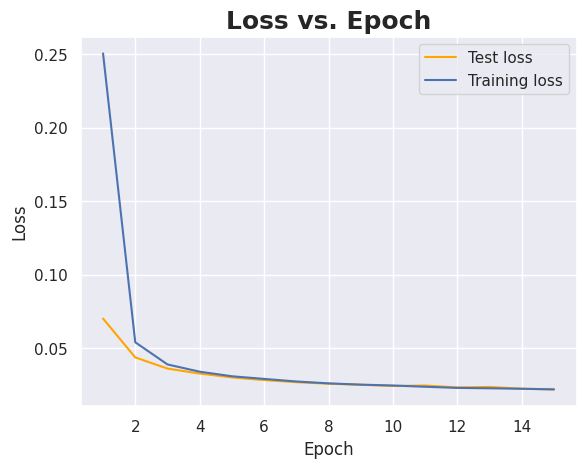

In [19]:
# summarize history for loss
train_loss = history.history['loss']
test_loss = history.history['val_loss']
x = list(range(1, len(test_loss) + 1))
plt.plot(x, test_loss, color = 'orange', label = 'Test loss')
plt.plot(x, train_loss, label = 'Training loss')
plt.legend()
plt.grid(visible=True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch', weight='bold', fontsize=18)
plt.show()

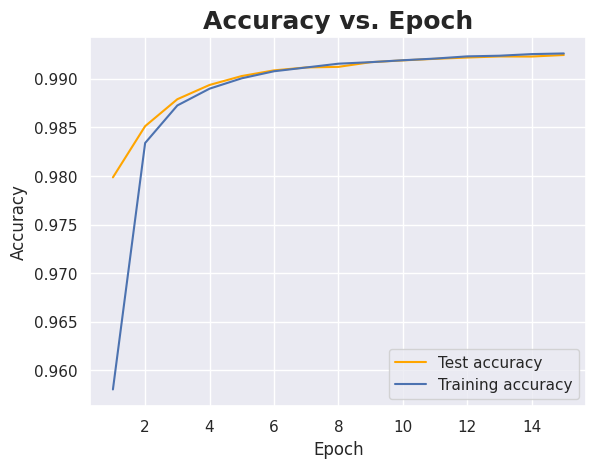

In [20]:
# summarize history for accuracy
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
x = list(range(1, len(test_acc) + 1))
plt.plot(x, test_acc, color = 'orange', label = 'Test accuracy')
plt.plot(x, train_acc, label = 'Training accuracy')
plt.legend()
plt.grid(visible=True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch', weight='bold', fontsize=18)
plt.show()

In [21]:
# Prediction
#model = load_model('/home/riki/project_dl/finale/model/base5_train_test.keras')
predicted1 = model.predict(x_test1)

3709/3709 [==============================] - 14s 4ms/step


In [22]:
df1 = pd.DataFrame(y_test1)
df1['predicted'] = predicted1

In [23]:
cf1 = confusion_matrix(y_test1, np.round(predicted1))

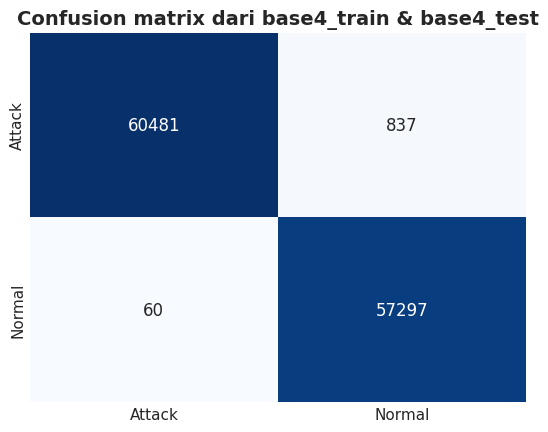

In [24]:
cmatrix_df1 = pd.DataFrame(cf1, index = ['Attack', 'Normal'], columns = ['Attack', 'Normal'])
plt.title('Confusion matrix dari base4_train & base4_test', weight='bold', fontsize=14)
plt.tick_params(length=0)
plt.xlabel('Attacks')
plt.ylabel('Predicted Attacks')
sns.heatmap(cmatrix_df1, annot=True, fmt="d", cbar=False, cmap='Blues')
plt.show()

In [25]:
# Precision, Recall & F1 Score
class_report1 = classification_report(y_test1, np.round(predicted1))
print(class_report1)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     61318
           1       0.99      1.00      0.99     57357

    accuracy                           0.99    118675
   macro avg       0.99      0.99      0.99    118675
weighted avg       0.99      0.99      0.99    118675



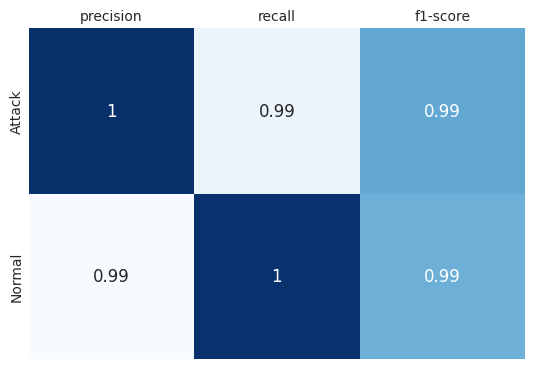

In [26]:
# Precision, Recall & F1-Score
class_report1 = classification_report(y_test1, np.round(predicted1), target_names = ['Attack', 'Normal'],output_dict=True) 
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.tick_params(length=0)
sns.heatmap(pd.DataFrame(class_report1).iloc[:-1, :-3].T, square=True, cbar=False,cmap='Blues', annot=True) 
plt.show()

In [27]:
model.save('~/04_Semester_4/revisi/tmp/base5_train_test.keras')

In [28]:
# adding normal column in data label
normal=data_labels['label']
normal=normal.replace(1,2)
normal=normal.replace(0,1)
normal=normal.replace(2,0)
data_labels.insert(1, 'normal', normal)

In [29]:
df1 = pd.DataFrame(np.round(predicted1))
df1.index = data.index
df1.columns = ['pred_attack']
df1['pred_normal'] = 1- df1['pred_attack']
df1['attack']=data['label']
df1['category']=data['attack_cat']
df1['normal']=data_labels['normal']
df1.head()

pred_attack  pred_normal  attack category  normal
0          1.0          0.0       1  generic       0
1          0.0          1.0       0   normal       1
3          1.0          0.0       1  generic       0
4          0.0          1.0       0   normal       1
5          1.0          0.0       1  generic       0

In [30]:
df1.value_counts('category')

category
normal            61318
generic           53520
reconnaissance     2883
dos                 954
Name: count, dtype: int64

In [31]:
dff1=df1
df1=pd.get_dummies(df1)
df1=round(df1)

normal, exploits, fuzzers, shellcode, worms

In [32]:
normal=df1.loc[df1['category_normal'] == 1]
normal=normal[['pred_attack', 'pred_normal', 'attack', 'normal']]
normal_pred=normal[['pred_attack','pred_normal']]
normal_check=normal[['attack','normal']]

generic=df1.loc[df1['category_generic'] == 1]
generic=generic[['pred_attack', 'pred_normal', 'attack', 'normal']]
generic_pred=generic[['pred_attack','pred_normal']]
generic_check=generic[['attack','normal']]

dos=df1.loc[df1['category_dos'] == 1]
dos=dos[['pred_attack', 'pred_normal', 'attack', 'normal']]
dos_pred=dos[['pred_attack','pred_normal']]
dos_check=dos[['attack','normal']]

reconnaissance=df1.loc[df1['category_reconnaissance'] == 1]
reconnaissance=reconnaissance[['pred_attack', 'pred_normal', 'attack', 'normal']]
reconnaissance_pred=reconnaissance[['pred_attack','pred_normal']]
reconnaissance_check=reconnaissance[['attack','normal']]

In [33]:
#Correctly detected
countdata=pd.DataFrame()
normal_c = normal['pred_normal'] * normal['normal']
generic_c = generic['pred_attack'] * generic['attack']
reconnaissance_c = reconnaissance['pred_attack'] * reconnaissance['attack']
dos_c = dos['pred_attack'] * dos['attack']

In [34]:
# Count 0 and 1
normal_c0 = (normal_c == 0).sum()
normal_c1 = len(normal) - normal_c0

reconnaissance_c0 = (reconnaissance_c == 0).sum()
reconnaissance_c1 = len(reconnaissance_c) - reconnaissance_c0

generic_c0 = (generic_c == 0).sum()
generic_c1 = len(generic) - generic_c0

dos_c0 = (dos_c == 0).sum()
dos_c1 = len(dos) - dos_c0

In [35]:
normal_0, normal_1 = normal_c0*100 / len(normal), normal_c1*100 / len(normal)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(normal_0, normal_1))

There are 1.37 % of NO detected and 98.63 % of detected samples


In [36]:
generic_0, generic_1 = generic_c0*100 / len(generic), generic_c1*100 / len(generic)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(generic_0, generic_1))

There are 0.05 % of NO detected and 99.95 % of detected samples


In [37]:
reconnaissance_0, reconnaissance_1 = reconnaissance_c0*100 / len(reconnaissance), reconnaissance_c1*100 / len(reconnaissance)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(reconnaissance_0, reconnaissance_1))

There are 0.10 % of NO detected and 99.90 % of detected samples


In [38]:
dos_0, dos_1 = dos_c0*100 / len(dos), dos_c1*100 / len(dos)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(dos_0, dos_1))

There are 3.25 % of NO detected and 96.75 % of detected samples


In [39]:
summary1 = pd.DataFrame({"Traffic":
                   ["Normal", "generic", "reconnaissance", "dos"],
                   "Detected %": [normal_1, generic_1, reconnaissance_1 ,dos_1],
                   "No Detected %": [normal_0, generic_0, reconnaissance_0 ,dos_0],
                   "Detected Samples": [normal_c1, generic_c1, reconnaissance_c1 ,dos_c1],
                   "No Detected Samples": [normal_c0, generic_c0, reconnaissance_c0 ,dos_c0]})

In [40]:
dff1['category_pred'] = np.where(((df1['attack'] == 1) & (df1['pred_attack'] == 1)) | ((df1['normal'] == 1) & (df1['pred_normal'] == 1)), 'Detected', 'No Detected')


In [41]:
data_plot1=dff1[['category', 'category_pred']]

In [42]:
data_plot1

category category_pred
0       generic      Detected
1        normal      Detected
3       generic      Detected
4        normal      Detected
5       generic      Detected
...         ...           ...
122905   normal      Detected
122906   normal      Detected
122907  generic      Detected
122908  generic      Detected
122909  generic      Detected

[118675 rows x 2 columns]

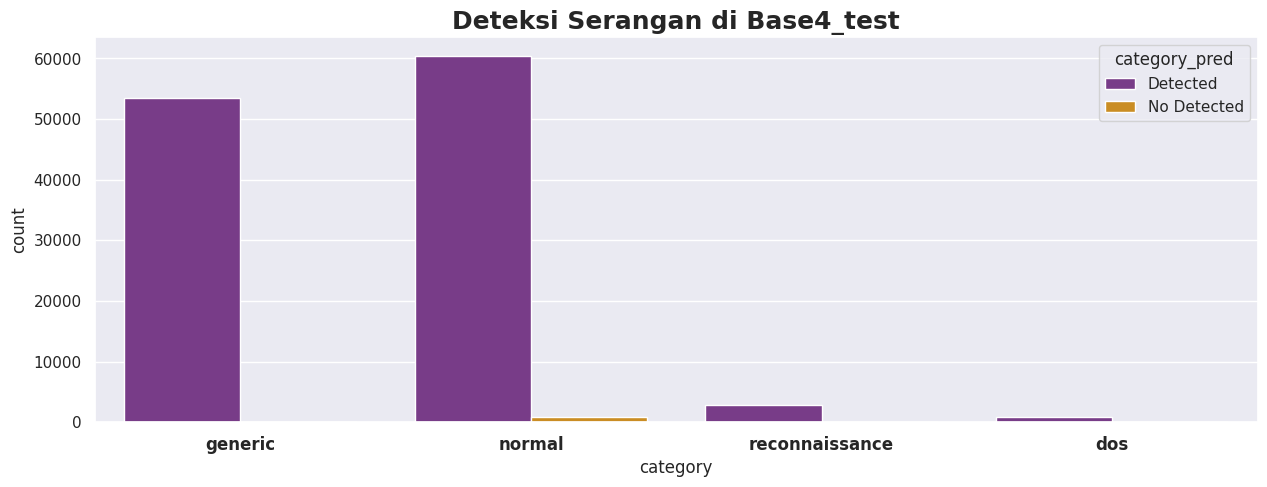

In [43]:
# Plotting target label distribution
plt.figure(figsize=(15,5))
sns.set_theme(style="darkgrid")
sns.countplot(x=data_plot1['category'], data=data_plot1, palette='CMRmap', hue=data_plot1['category_pred'])
plt.title('Deteksi Serangan di Base4_test', weight='bold', fontsize='18')
plt.xticks(weight='bold', fontsize=12)
plt.show()

In [44]:
summary1

Traffic  Detected %  No Detected %  Detected Samples  \
0          Normal   98.634985       1.365015             60481   
1         generic   99.951420       0.048580             53494   
2  reconnaissance   99.895942       0.104058              2880   
3             dos   96.750524       3.249476               923   

   No Detected Samples  
0                  837  
1                   26  
2                    3  
3                   31

In [46]:
summary1.to_csv('~/04_Semester_4/revisi/csv_files/summary_base4_train_test.csv', index=False)

In [45]:
model.save('base4_train_test_24_512.keras')

## Base 4 Train & First Test

In [46]:
# Load base 5 data train
data_train = pd.read_csv('~/04_Semester_4/revisi/csv_files/UNSW_NB15_base4_train.csv', low_memory=False)

In [47]:
# Select the 'proto' and 'state' values
data_train= data_train.loc[(data_train['proto'] == 'tcp') | (data_train['proto'] =='udp') | (data_train['proto'] =='icmp') | (data_train['proto'] =='arp') | (data_train['proto'] =='ipv6-icmp') | (data_train['proto'] =='igmp') | (data_train['proto'] =='rarp'), :]
data_train = data_train.loc[(data_train['state'] == 'RST') | (data_train['state'] =='REQ') | (data_train['state'] =='INT') | (data_train['state'] =='FIN') | (data_train['state'] =='CON') | (data_train['state'] =='ECO') | (data_train['state'] =='ACC') | (data_train['state'] =='PAR'), :]

# Extracting dataset labels
data_labels=data_train[['label']]

# Drop the invalid features and select data features
data_features=data_train[['proto','srcip','sport','dstip','dsport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]

# Filling NaN values with -1
data_features = data_features.fillna(value=-1)

In [48]:
# Preprocess IP and ports features
# IP Source Address
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(".")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(":")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(".")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(":")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dsport'] = data_features['dsport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dsport'] = data_features['dsport'].apply(lambda x: "None" if x=="-" else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)

# Generate 1 new columns to fit with training
#auxCol=data_features['sbytes']
#auxCol=0
#data_features.insert(13, 'proto_igmp', auxCol, True)

# Transform to One hot encoding - FEATURES
data_features=pd.get_dummies(data_features)
data_labels = pd.get_dummies(data_labels)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)

x_train2, y_train2=data_features, data_labels

In [49]:
print(x_train2.shape)
print(y_train2.shape)
print(y_train2.value_counts())

(356047, 24, 1)
(356047, 1)
label
0        183969
1        172078
Name: count, dtype: int64


In [50]:
# Load base 5+ test
data = pd.read_csv('~/04_Semester_4/revisi/csv_files/UNSW_NB15_first_test.csv', low_memory=False)

In [51]:
data_train.value_counts('attack_cat')

attack_cat
normal            183969
generic           160198
reconnaissance      8971
dos                 2909
Name: count, dtype: int64

In [52]:
data.value_counts('attack_cat')

attack_cat
normal       75462
exploits     44525
fuzzers      24246
analysis      2677
backdoor      2329
shellcode     1511
worms          174
Name: count, dtype: int64

In [53]:
# Select the 'proto' and 'state' values that I want
data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='ipv6-icmp') | (data['proto'] =='igmp') | (data['proto'] =='rarp'), :]
data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] =='PAR'), :]

# Extracting dataset labels
data_labels=data[['label']]

# Drop the invalid features and select interested data features
data_features=data[['proto','srcip','sport','dstip','dsport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]

"""PREPROCESSING"""

# Preprocess IP and ports features
# IP Source Address
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(".")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(":")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(".")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(":")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dsport'] = data_features['dsport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dsport'] = data_features['dsport'].apply(lambda x: "None" if x=="-" else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert field to int format
data_features['srcip'] = data_features['srcip'].astype(int)
data_features['sport'] = data_features['sport'].astype(int)
data_features['dstip'] = data_features['dstip'].astype(int)
data_features['dsport'] = data_features['dsport'].astype(int)

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)
    
# Generate 1 new columns to fit with training
#auxCol=data_features['sbytes']
#auxCol=0
#data_features.insert(13, 'proto_igmp', auxCol, True)
  
# Insert the new column in data labels
data_labels = pd.get_dummies(data_labels)

# Transform to One hot encoding - FEATURES
data_features=pd.get_dummies(data_features)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)

x_test2, y_test2 = data_features, data_labels

In [54]:
print(x_test2.shape)
print(y_test2.shape)
print(y_test2.value_counts())

(127810, 24, 1)
(127810, 1)
label
0        75312
1        52498
Name: count, dtype: int64


In [55]:
# Early Stopping

filepath = '~04_Semester_4/revisi/tmp/firsttest_checkpoint.model.keras' # define where the model is saved
callbacks = [
        keras.callbacks.EarlyStopping(
            monitor = 'val_loss', # Use accuracy to monitor the model
            patience = 15 # Stop after 2 steps with lower accuracy
        ),
        keras.callbacks.ModelCheckpoint(
            filepath = filepath, # file where the checkpoint is saved
            monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
            save_best_only = True)]# Only save model if it is the best

In [56]:
# Clear session and Memory Growth
clear_session()

# Create a Strategy.
mixed_precision.set_global_policy('mixed_float16')

if tf.config.list_physical_devices('GPU'):
    strategy = tf.distribute.MirroredStrategy()
else:  # Use the Default Strategy
    strategy = tf.distribute.get_strategy()

print("Number of devices: {}".format(strategy.num_replicas_in_sync))

# Open a strategy scope.
with strategy.scope():

    model=model_cnn()

    #x_train, x_test, y_train, y_test = train_test_split(data_features, data_labels, train_size=0.75, random_state=42,shuffle=True)


# Train the model on all available devices.
history = model.fit(x_train2, y_train2, validation_data=(x_test2, y_test2), epochs=15, batch_size=2048, callbacks=callbacks)
history2 = history

Physical devices cannot be modified after being initialized
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1
Epoch 1/15
174/174 [==============================] - 46s 254ms/step - loss: 0.2457 - accuracy: 0.9538 - val_loss: 0.4773 - val_accuracy: 0.8223
Epoch 2/15
174/174 [==============================] - 43s 248ms/step - loss: 0.0552 - accuracy: 0.9831 - val_loss: 0.2901 - val_accuracy: 0.8987
Epoch 3/15
174/174 [==============================] - 43s 249ms/step - loss: 0.0387 - accuracy: 0.9871 - val_loss: 0.2217 - val_accuracy: 0.9364
Epoch 4/15
174/174 [==============================] - 43s 247ms/step - loss: 0.0336 - accuracy: 0.9891 - val_loss: 0.2045 - val_accuracy: 0.9514
Epoch 5/15
174/174 [==============================] - 42s 244ms/step - loss: 0.0311 - accuracy: 0.9899 - val_loss: 0.1915 - val_accuracy: 0.9618
Epoch 6/15
174/174 [==============================] - 43s 248ms/step - loss: 0.0292 - accura

In [57]:
#Evaluate the model
# 174/174 [==============================] - 42s 244ms/step - loss: 0.0154 - accuracy: 0.9940 - val_loss: 0.3748 - val_accuracy: 0.8247
# 174/174 [==============================] - 43s 246ms/step - loss: 0.0162 - accuracy: 0.9938 - val_loss: 0.9160 - val_accuracy: 0.7435

results2 = model.evaluate(x_test2, y_test2, verbose=1)
print("test loss, test acc:", results2)

3995/3995 [==============================] - 23s 6ms/step - loss: 0.3362 - accuracy: 0.8239
test loss, test acc: [0.33624178171157837, 0.8239261507987976]


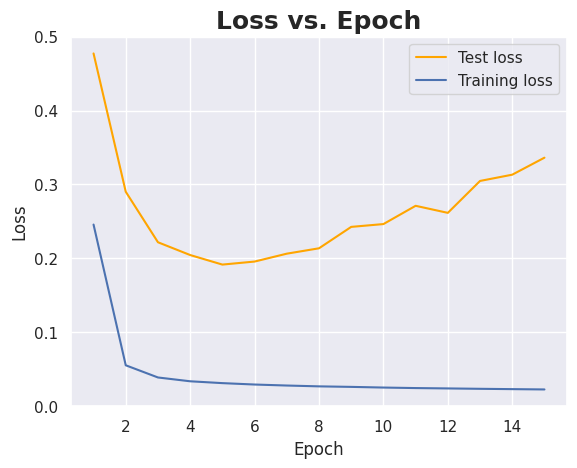

In [58]:
# summarize history for loss
train_loss = history.history['loss']
test_loss = history.history['val_loss']
x = list(range(1, len(test_loss) + 1))
plt.plot(x, test_loss, color = 'orange', label = 'Test loss')
plt.plot(x, train_loss, label = 'Training loss')
plt.legend()
plt.grid(visible=True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch', weight='bold', fontsize=18)
plt.show()

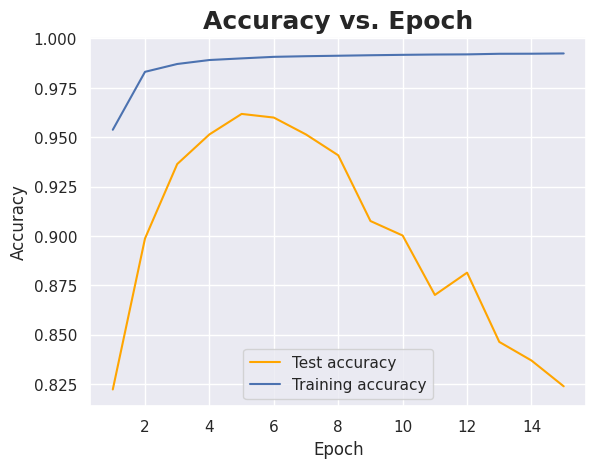

In [59]:
# summarize history for accuracy
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
x = list(range(1, len(test_acc) + 1))
plt.plot(x, test_acc, color = 'orange', label = 'Test accuracy')
plt.plot(x, train_acc, label = 'Training accuracy')
plt.legend()
plt.grid(visible=True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch', weight='bold', fontsize=18)
plt.show()

In [60]:
# Prediction
predicted2 = model.predict(x_test2)

3995/3995 [==============================] - 15s 4ms/step


In [61]:
df2 = pd.DataFrame(y_test2)
df2['predicted'] = predicted2

In [62]:
cf2 = confusion_matrix(y_test2, np.round(predicted2))

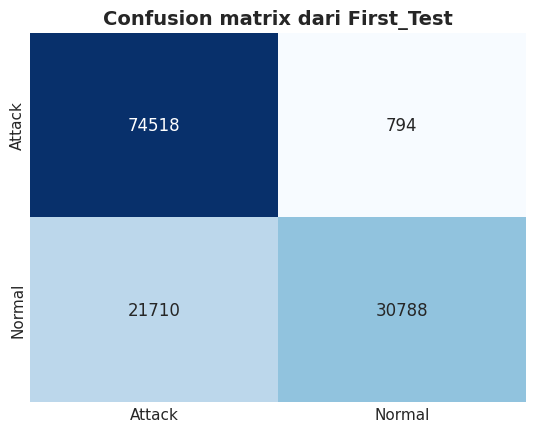

In [63]:
cmatrix_df2 = pd.DataFrame(cf2, index = ['Attack', 'Normal'], columns = ['Attack', 'Normal'])
plt.title('Confusion matrix dari First_Test', weight='bold', fontsize=14)
plt.tick_params(length=0)
plt.xlabel('Attacks')
plt.ylabel('Predicted Attacks')
sns.heatmap(cmatrix_df2, annot=True, fmt="d", cbar=False, cmap='Blues')
plt.show()

In [64]:
# Precision, Recall & F1 Score
class_report2 = classification_report(y_test2, np.round(predicted2))
print(class_report2)

              precision    recall  f1-score   support

           0       0.77      0.99      0.87     75312
           1       0.97      0.59      0.73     52498

    accuracy                           0.82    127810
   macro avg       0.87      0.79      0.80    127810
weighted avg       0.86      0.82      0.81    127810



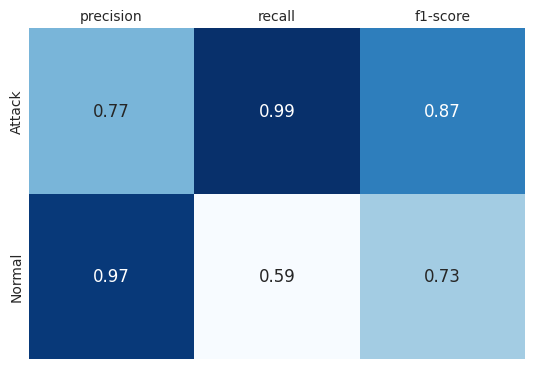

In [65]:
# Precision, Recall & F1-Score
class_report2 = classification_report(y_test2, np.round(predicted2), target_names = ['Attack', 'Normal'],output_dict=True) 
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.tick_params(length=0)
sns.heatmap(pd.DataFrame(class_report2).iloc[:-1, :-3].T, square=True, cbar=False,cmap='Blues', annot=True) 
plt.show()

In [66]:
model.save('first_test_24_512.keras')

In [67]:
# adding normal column in data label
normal=data_labels['label']
normal=normal.replace(1,2)
normal=normal.replace(0,1)
normal=normal.replace(2,0)
data_labels.insert(1, 'normal', normal)

In [68]:
df2 = pd.DataFrame(np.round(predicted2))
df2.index = data.index
df2.columns = ['pred_attack']
df2['pred_normal'] = 1- df2['pred_attack']
df2['attack']=data['label']
df2['category']=data['attack_cat']
df2['normal']=data_labels['normal']
df2.head()

pred_attack  pred_normal  attack  category  normal
0          1.0          0.0       1  exploits       0
1          1.0          0.0       1  exploits       0
2          0.0          1.0       1  exploits       0
3          1.0          0.0       1  exploits       0
4          1.0          0.0       1  exploits       0

In [69]:
df2.value_counts('category')

category
normal       75312
exploits     28317
fuzzers      21517
shellcode     1511
analysis       622
backdoor       357
worms          174
Name: count, dtype: int64

In [70]:
dff2=df2
df2=pd.get_dummies(df2)
df2=round(df2)

In [71]:
normal=df2.loc[df2['category_normal'] == 1]
normal=normal[['pred_attack', 'pred_normal', 'attack', 'normal']]
normal_pred=normal[['pred_attack','pred_normal']]
normal_check=normal[['attack','normal']]

exploits=df2.loc[df2['category_exploits'] == 1]
exploits=exploits[['pred_attack', 'pred_normal', 'attack', 'normal']]
exploits_pred=exploits[['pred_attack','pred_normal']]
exploits_check=exploits[['attack','normal']]

fuzzers=df2.loc[df2['category_fuzzers'] == 1]
fuzzers=fuzzers[['pred_attack', 'pred_normal', 'attack', 'normal']]
fuzzers_pred=fuzzers[['pred_attack','pred_normal']]
fuzzers_check=fuzzers[['attack','normal']]

analysis=df2.loc[df2['category_analysis'] == 1]
analysis=analysis[['pred_attack', 'pred_normal', 'attack', 'normal']]
analysis_pred=analysis[['pred_attack','pred_normal']]
analysis_check=analysis[['attack','normal']]

backdoor=df2.loc[df2['category_backdoor'] == 1]
backdoor=backdoor[['pred_attack', 'pred_normal', 'attack', 'normal']]
backdoor_pred=backdoor[['pred_attack','pred_normal']]
backdoor_check=backdoor[['attack','normal']]

shellcode=df2.loc[df2['category_shellcode'] == 1]
shellcode=shellcode[['pred_attack', 'pred_normal', 'attack', 'normal']]
shellcode_pred=shellcode[['pred_attack','pred_normal']]
shellcode_check=shellcode[['attack','normal']]

worms=df2.loc[df2['category_worms'] == 1]
worms=worms[['pred_attack', 'pred_normal', 'attack', 'normal']]
worms_pred=worms[['pred_attack','pred_normal']]
worms_check=worms[['attack','normal']]

In [72]:
#Correctly detected
countdata=pd.DataFrame()
normal_c = normal['pred_normal'] * normal['normal']
exploits_c = exploits['pred_attack'] * exploits['attack']
fuzzers_c = fuzzers['pred_attack'] * fuzzers['attack']
analysis_c = analysis['pred_attack'] * analysis['attack']
backdoor_c = backdoor['pred_attack'] * backdoor['attack']
shellcode_c = shellcode['pred_attack'] * shellcode['attack']
worms_c = worms['pred_attack'] * worms['attack']

In [73]:
# Count 0 and 1
normal_c0 = (normal_c == 0).sum()
normal_c1 = len(normal) - normal_c0

exploits_c0 = (exploits_c == 0).sum()
exploits_c1 = len(exploits) - exploits_c0

fuzzers_c0 = (fuzzers_c == 0).sum()
fuzzers_c1 = len(fuzzers) - fuzzers_c0

analysis_c0 = (analysis_c == 0).sum()
analysis_c1 = len(analysis) - analysis_c0

backdoor_c0 = (backdoor_c == 0).sum()
backdoor_c1 = len(backdoor) - backdoor_c0

shellcode_c0 = (shellcode_c == 0).sum()
shellcode_c1 = len(shellcode) - shellcode_c0

worms_c0 = (worms_c == 0).sum()
worms_c1 = len(worms) - worms_c0

In [74]:
normal_0, normal_1 = normal_c0*100 / len(normal), normal_c1*100 / len(normal)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(normal_0, normal_1))

There are 1.05 % of NO detected and 98.95 % of detected samples


In [75]:
exploits_0, exploits_1 = exploits_c0*100 / len(exploits), exploits_c1*100 / len(exploits)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(exploits_0, exploits_1))

There are 34.47 % of NO detected and 65.53 % of detected samples


In [76]:
fuzzers_0, fuzzers_1 = fuzzers_c0*100 / len(fuzzers), fuzzers_c1*100 / len(fuzzers)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(fuzzers_0, fuzzers_1))

There are 51.83 % of NO detected and 48.17 % of detected samples


In [77]:
analysis_0, analysis_1 = analysis_c0*100 / len(analysis), analysis_c1*100 / len(analysis)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(analysis_0, analysis_1))

There are 58.36 % of NO detected and 41.64 % of detected samples


In [78]:
backdoor_0, backdoor_1 = backdoor_c0*100 / len(backdoor), backdoor_c1*100 / len(backdoor)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(backdoor_0, backdoor_1))

There are 31.65 % of NO detected and 68.35 % of detected samples


In [79]:
shellcode_0, shellcode_1 = shellcode_c0*100 / len(shellcode), shellcode_c1*100 / len(shellcode)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(shellcode_0, shellcode_1))

There are 14.16 % of NO detected and 85.84 % of detected samples


In [80]:
worms_0, worms_1 = worms_c0*100 / len(worms), worms_c1*100 / len(worms)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(worms_0, worms_1))

There are 61.49 % of NO detected and 38.51 % of detected samples


attack_cat
normal       30937
fuzzers      24246
analysis      2677
backdoor      2329
shellcode     1511
worms          174

In [81]:
summary2 = pd.DataFrame({"Traffic":
                   ["Normal", "Exploits","Fuzzers", "Analysis", "Backdoor", "Shellcode", "Worms"],
                   "Detected %": [normal_1, exploits_1, fuzzers_1,analysis_1, backdoor_1, shellcode_1, worms_1],
                   "No Detected %": [normal_0, exploits_0, fuzzers_0, analysis_0, backdoor_0, shellcode_0, worms_0],
                   "Detected Samples": [normal_c1, exploits_c1, fuzzers_c1, analysis_c1, backdoor_c1, shellcode_c1, worms_c1],
                   "No Detected Samples": [normal_c0,  exploits_c0, fuzzers_c0, analysis_c0, backdoor_c0, shellcode_c0, worms_c1]})

In [82]:
dff2['category_pred'] = np.where(((df2['attack'] == 1) & (df2['pred_attack'] == 1)) | ((df2['normal'] == 1) & (df2['pred_normal'] == 1)), 'Detected', 'No Detected')

In [83]:
data_plot2=dff2[['category', 'category_pred']]

In [84]:
data_plot2

category category_pred
0       exploits      Detected
1       exploits      Detected
2       exploits   No Detected
3       exploits      Detected
4       exploits      Detected
...          ...           ...
150919    normal      Detected
150920    normal      Detected
150921    normal      Detected
150922    normal      Detected
150923    normal      Detected

[127810 rows x 2 columns]

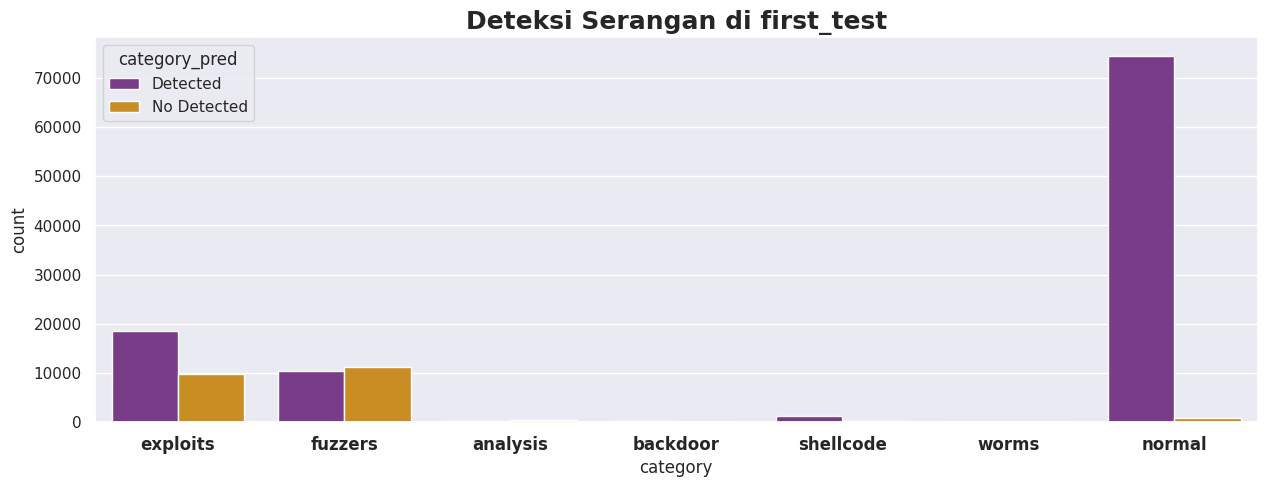

In [85]:
# Plotting target label distribution
plt.figure(figsize=(15,5))
sns.set_theme(style="darkgrid")
sns.countplot(x=data_plot2['category'], data=data_plot2,palette='CMRmap', hue=data_plot2['category_pred'])
plt.title('Deteksi Serangan di first_test', weight='bold', fontsize='18')
plt.xticks(weight='bold', fontsize=12)
plt.show()

In [86]:
summary2

Traffic  Detected %  No Detected %  Detected Samples  No Detected Samples
0     Normal   98.945719       1.054281             74518                  794
1   Exploits   65.529541      34.470459             18556                 9761
2    Fuzzers   48.171213      51.828787             10365                11152
3   Analysis   41.639871      58.360129               259                  363
4   Backdoor   68.347339      31.652661               244                  113
5  Shellcode   85.837194      14.162806              1297                  214
6      Worms   38.505747      61.494253                67                   67

In [167]:
summary2.to_csv('~/04_Semester_4/revisi/csv_files/summary_first_test.csv', index=False)

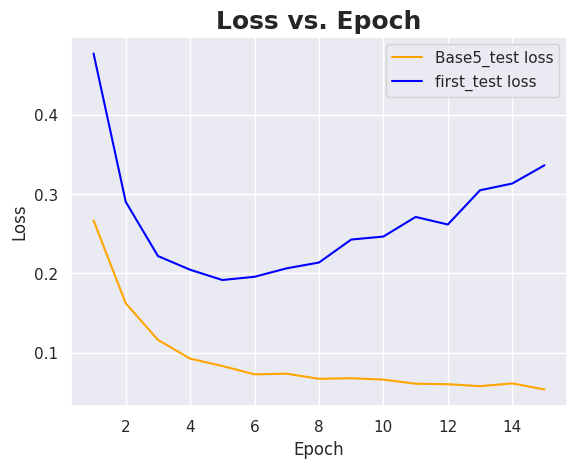

In [126]:
# summarize history for accuracy
loss_1 = history1.history['val_loss']
loss_2 = history2.history['val_loss']
x = list(range(1, len(loss_1) + 1))
plt.plot(x, loss_1, color = 'orange', label = 'Base5_test loss')
plt.plot(x, loss_2, color = 'blue', label = 'first_test loss')
plt.legend()
plt.grid(visible=True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch', weight='bold', fontsize=18)
plt.show()

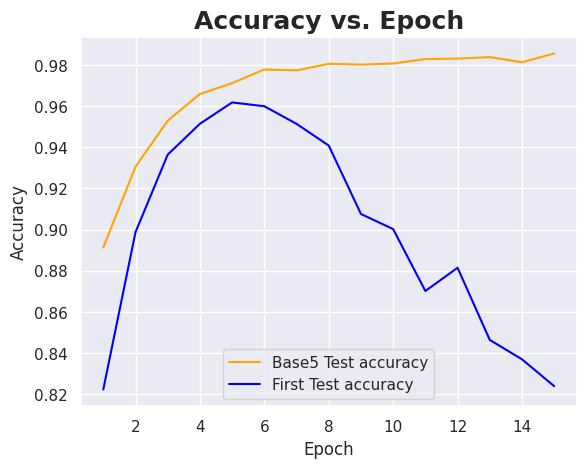

In [127]:
# summarize history for loss
acc_1 = history1.history['val_accuracy']
acc_2 = history2.history['val_accuracy']
x = list(range(1, len(acc_1) + 1))
plt.plot(x, acc_1, color = 'orange', label = 'Base5 Test accuracy')
plt.plot(x, acc_2, color = 'blue', label = 'First Test accuracy')
plt.legend()
plt.grid(visible=True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch', weight='bold', fontsize=18)
plt.show()

### C. Base4 Train & Full Test

In [128]:
x_train3, y_train3 = x_train2, y_train2

In [129]:
data = pd.read_csv('~/04_Semester_4/revisi/csv_files/UNSW_NB15_full_test.csv', low_memory=False)

In [130]:
# Select the 'proto' and 'state' values that I want
data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='ipv6-icmp') | (data['proto'] =='igmp') | (data['proto'] =='rarp'), :]
data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] =='PAR'), :]

# Extracting dataset labels
data_labels=data[['label']]

# Drop the invalid features and select interested data features
data_features=data[['proto','srcip','sport','dstip','dsport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]

# Filling NaN values with -1
data_features = data_features.fillna(value=-1)

"""PREPROCESSING"""

# Preprocess IP and ports features
# IP Source Address
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(".")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(":")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(".")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(":")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dsport'] = data_features['dsport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dsport'] = data_features['dsport'].apply(lambda x: "None" if x=="-" else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert field to int format
data_features['srcip'] = data_features['srcip'].astype(int)
data_features['sport'] = data_features['sport'].astype(int)
data_features['dstip'] = data_features['dstip'].astype(int)
data_features['dsport'] = data_features['dsport'].astype(int)

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)


    
# Insert the new column in data labels
data_labels = pd.get_dummies(data_labels)

# Transform to One hot encoding - FEATURES
data_features=pd.get_dummies(data_features)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)

x_test3, y_test3=data_features, data_labels

In [131]:
print(x_test3.shape)
print(y_test3.shape)
print(y_test3.value_counts())

(602526, 24, 1)
(602526, 1)
label
0        320593
1        281933
Name: count, dtype: int64


In [132]:
#Evaluate the model
model1 = model
results4 = model1.evaluate(x_test3, y_test3, verbose=1)
#test loss, test acc: [0.048502471297979355, 0.9808921217918396]

print("test loss, test acc:", results4)

18829/18829 [==============================] - 108s 6ms/step - loss: 0.0535 - accuracy: 0.9856
test loss, test acc: [0.05349274352192879, 0.9855973124504089]


In [ ]:
# Clear session and Memory Growth
clear_session()

# Create a Strategy.
mixed_precision.set_global_policy('mixed_float16')

if tf.config.list_physical_devices('GPU'):
    strategy = tf.distribute.MirroredStrategy()
else:  # Use the Default Strategy
    strategy = tf.distribute.get_strategy()

print("Number of devices: {}".format(strategy.num_replicas_in_sync))

# Open a strategy scope.
with strategy.scope():

    model=model_cnn()

    #x_train, x_test, y_train, y_test = train_test_split(data_features, data_labels, train_size=0.75, random_state=42,shuffle=True)


# Train the model on all available devices.
history = model.fit(x_train3, y_train3, validation_data=(x_test3, y_test3), epochs=15, batch_size=2048, callbacks=callbacks, verbose=1)
history1 = history

In [135]:
# Prediction
predicted3 = model1.predict(x_test3)

18829/18829 [==============================] - 76s 4ms/step


In [136]:
df3 = pd.DataFrame(y_test3)
df3['predicted'] = predicted3

In [137]:
cf3 = confusion_matrix(y_test3, np.round(predicted3))

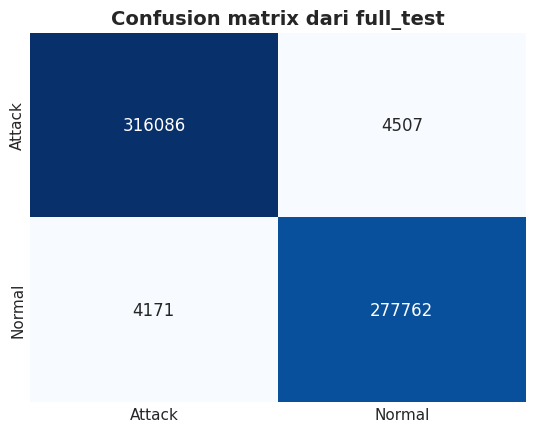

In [138]:
cmatrix_df3 = pd.DataFrame(cf3, index = ['Attack', 'Normal'], columns = ['Attack', 'Normal'])
plt.title('Confusion matrix dari full_test', weight='bold', fontsize=14)
plt.tick_params(length=0)
plt.xlabel('Attacks')
plt.ylabel('Predicted Attacks')
sns.heatmap(cmatrix_df3, annot=True, fmt="d", cbar=False, cmap='Blues')
plt.show()

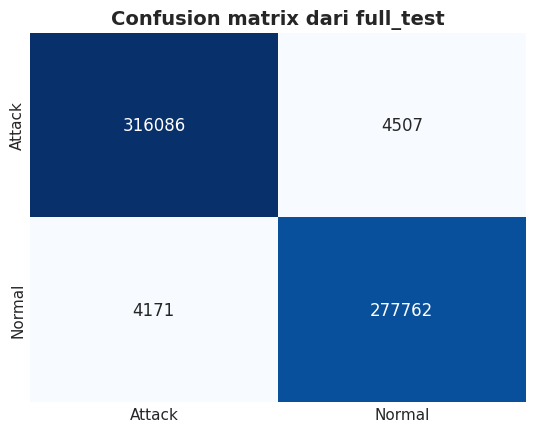

In [139]:
cmatrix_df3 = pd.DataFrame(cf3, index = ['Attack', 'Normal'], columns = ['Attack', 'Normal'])
plt.title('Confusion matrix dari full_test', weight='bold', fontsize=14)
plt.tick_params(length=0)
plt.xlabel('Attacks')
plt.ylabel('Predicted Attacks')
sns.heatmap(cmatrix_df3, annot=True, fmt="d", cbar=False, cmap='Blues')
plt.show()

In [140]:
# Precision, Recall & F1 Score
class_report3 = classification_report(y_test3, np.round(predicted3))
print(class_report3)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    320593
           1       0.98      0.99      0.98    281933

    accuracy                           0.99    602526
   macro avg       0.99      0.99      0.99    602526
weighted avg       0.99      0.99      0.99    602526



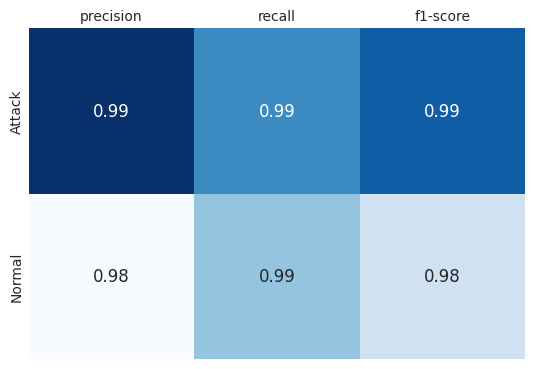

In [141]:
# Precision, Recall & F1-Score
class_report3 = classification_report(y_test3, np.round(predicted3), target_names = ['Attack', 'Normal'],output_dict=True) 
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.tick_params(length=0)
sns.heatmap(pd.DataFrame(class_report3).iloc[:-1, :-3].T, square=True, cbar=False,cmap='Blues', annot=True) 
plt.show()

In [142]:
class_report3

{'Attack': {'precision': 0.9869760848318694,
  'recall': 0.9859416768301241,
  'f1-score': 0.9864586096590465,
  'support': 320593.0},
 'Normal': {'precision': 0.9840329614658357,
  'recall': 0.9852057049015192,
  'f1-score': 0.9846189839809146,
  'support': 281933.0},
 'accuracy': 0.9855973020251408,
 'macro avg': {'precision': 0.9855045231488526,
  'recall': 0.9855736908658217,
  'f1-score': 0.9855387968199806,
  'support': 602526.0},
 'weighted avg': {'precision': 0.9855989432646075,
  'recall': 0.9855973020251408,
  'f1-score': 0.9855978149608713,
  'support': 602526.0}}

In [143]:
# adding normal column in data label
normal=data_labels['label']
normal=normal.replace(1,2)
normal=normal.replace(0,1)
normal=normal.replace(2,0)
data_labels.insert(1, 'normal', normal)

In [144]:
df3 = pd.DataFrame(np.round(predicted3))
df3.index = y_test3.index
df3.columns = ['pred_attack']
df3['pred_normal'] = 1- df3['pred_attack']
df3['attack']=data['label']
df3['category']=data['attack_cat']
df3['normal']=data_labels['normal']
df3.head()

pred_attack  pred_normal  attack        category  normal
0          1.0          0.0       1        exploits       0
1          1.0          0.0       1        exploits       0
2          1.0          0.0       1  reconnaissance       0
3          1.0          0.0       1        exploits       0
4          1.0          0.0       1        exploits       0

In [145]:
df3.value_counts('category')

category
normal            320593
generic           213718
exploits           28317
fuzzers            21517
reconnaissance     11854
dos                 3863
shellcode           1511
analysis             622
backdoor             357
worms                174
Name: count, dtype: int64

In [146]:
dff3=df3
df3=pd.get_dummies(df3)
df3=round(df3)

In [147]:
analysis=df3.loc[df3['category_analysis'] == 1]
analysis=analysis[['pred_attack', 'pred_normal', 'attack', 'normal']]
analysis_pred=analysis[['pred_attack','pred_normal']]
analysis_check=analysis[['attack','normal']]

backdoor=df3.loc[df3['category_backdoor'] == 1]
backdoor=backdoor[['pred_attack', 'pred_normal', 'attack', 'normal']]
backdoor_pred=backdoor[['pred_attack','pred_normal']]
backdoor_check=backdoor[['attack','normal']]

fuzzers=df3.loc[df3['category_fuzzers'] == 1]
fuzzers=fuzzers[['pred_attack', 'pred_normal', 'attack', 'normal']]
fuzzers_pred=fuzzers[['pred_attack','pred_normal']]
fuzzers_check=fuzzers[['attack','normal']]

normal=df3.loc[df3['category_normal'] == 1]
normal=normal[['pred_attack', 'pred_normal', 'attack', 'normal']]
normal_pred=normal[['pred_attack','pred_normal']]
normal_check=normal[['attack','normal']]

shellcode=df3.loc[df3['category_shellcode'] == 1]
shellcode=shellcode[['pred_attack', 'pred_normal', 'attack', 'normal']]
shellcode_pred=shellcode[['pred_attack','pred_normal']]
shellcode_check=shellcode[['attack','normal']]

worms=df3.loc[df3['category_worms'] == 1]
worms=worms[['pred_attack', 'pred_normal', 'attack', 'normal']]
worms_pred=worms[['pred_attack','pred_normal']]
worms_check=worms[['attack','normal']]

generic=df3.loc[df3['category_generic'] == 1]
generic=generic[['pred_attack', 'pred_normal', 'attack', 'normal']]
generic_pred=generic[['pred_attack','pred_normal']]
generic_check=generic[['attack','normal']]

exploits=df3.loc[df3['category_exploits'] == 1]
exploits=exploits[['pred_attack', 'pred_normal', 'attack', 'normal']]
exploits_pred=exploits[['pred_attack','pred_normal']]
exploits_check=exploits[['attack','normal']]

reconnaissance=df3.loc[df3['category_reconnaissance'] == 1]
reconnaissance=reconnaissance[['pred_attack', 'pred_normal', 'attack', 'normal']]
reconnaissance_pred=reconnaissance[['pred_attack','pred_normal']]
reconnaissance_check=reconnaissance[['attack','normal']]

dos=df3.loc[df3['category_dos'] == 1]
dos=dos[['pred_attack', 'pred_normal', 'attack', 'normal']]
dos_pred=dos[['pred_attack','pred_normal']]
dos_check=dos[['attack','normal']]

In [148]:
#Correctly detected
countdata=pd.DataFrame()
normal_c = normal['pred_normal'] * normal['normal']
analysis_c = analysis['pred_attack'] * analysis['attack']
backdoor_c = backdoor['pred_attack'] * backdoor['attack']
fuzzers_c = fuzzers['pred_attack'] * fuzzers['attack']
shellcode_c = shellcode['pred_attack'] * shellcode['attack']
worms_c = worms['pred_attack'] * worms['attack']
generic_c = generic['pred_attack'] * generic['attack']
exploits_c = exploits['pred_attack'] * exploits['attack']
reconnaissance_c = reconnaissance['pred_attack'] * reconnaissance['attack']
dos_c = dos['pred_attack'] * dos['attack']

In [149]:
# Count 0 and 1
normal_c0 = (normal_c == 0).sum()
normal_c1 = len(normal) - normal_c0

analysis_c0 = (analysis_c == 0).sum()
analysis_c1 = len(analysis) - analysis_c0

backdoor_c0 = (backdoor_c == 0).sum()
backdoor_c1 = len(backdoor) - backdoor_c0

fuzzers_c0 = (fuzzers_c == 0).sum()
fuzzers_c1 = len(fuzzers) - fuzzers_c0

shellcode_c0 = (shellcode_c == 0).sum()
shellcode_c1 = len(shellcode) - shellcode_c0

worms_c0 = (worms_c == 0).sum()
worms_c1 = len(worms) - worms_c0

generic_c0 = (generic_c == 0).sum()
generic_c1 = len(generic) - generic_c0

exploits_c0 = (exploits_c == 0).sum()
exploits_c1 = len(exploits) - exploits_c0

reconnaissance_c0 = (reconnaissance_c == 0).sum()
reconnaissance_c1 = len(reconnaissance) - reconnaissance_c0

dos_c0 = (dos_c == 0).sum()
dos_c1 = len(dos) - dos_c0

In [150]:
normal_0, normal_1 = normal_c0*100 / len(normal), normal_c1*100 / len(normal)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(normal_0, normal_1))

There are 1.41 % of NO detected and 98.59 % of detected samples


In [151]:
analysis_0, analysis_1 = analysis_c0*100 / len(analysis), analysis_c1*100 / len(analysis)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(analysis_0, analysis_1))

There are 2.41 % of NO detected and 97.59 % of detected samples


In [152]:
backdoor_0, backdoor_1 = backdoor_c0*100 / len(backdoor), backdoor_c1*100 / len(backdoor)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(backdoor_0, backdoor_1))

There are 17.93 % of NO detected and 82.07 % of detected samples


In [153]:
fuzzers_0, fuzzers_1 = fuzzers_c0*100 / len(fuzzers), fuzzers_c1*100 / len(fuzzers)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(fuzzers_0, fuzzers_1))


There are 4.06 % of NO detected and 95.94 % of detected samples


In [154]:
shellcode_0, shellcode_1 = shellcode_c0*100 / len(shellcode), shellcode_c1*100 / len(shellcode)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(shellcode_0, shellcode_1))

There are 15.35 % of NO detected and 84.65 % of detected samples


In [155]:
worms_0, worms_1 = worms_c0*100 / len(worms), worms_c1*100 / len(worms)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(worms_0, worms_1))

There are 2.87 % of NO detected and 97.13 % of detected samples


In [156]:
generic_0, generic_1 = generic_c0*100 / len(generic), generic_c1*100 / len(generic)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(generic_0, generic_1))


There are 0.08 % of NO detected and 99.92 % of detected samples


In [157]:
exploits_0, exploits_1 = exploits_c0*100 / len(exploits), exploits_c1*100 / len(exploits)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(exploits_0, exploits_1))

There are 9.10 % of NO detected and 90.90 % of detected samples


In [158]:
reconnaissance_0, reconnaissance_1 = reconnaissance_c0*100 / len(reconnaissance), reconnaissance_c1*100 / len(reconnaissance)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(reconnaissance_0, reconnaissance_1))

There are 0.16 % of NO detected and 99.84 % of detected samples


In [159]:
dos_0, dos_1 = dos_c0*100 / len(dos), dos_c1*100 / len(dos)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(dos_0, dos_1))

There are 5.51 % of NO detected and 94.49 % of detected samples


In [160]:
summary4 = pd.DataFrame({"Traffic":
                   ["Normal", "Analysis", "Backdoor", "Fuzzers", "Shellcode", "Worms", "Generic", "Exploits", "Reconnaissance", "DoS"],
                   "Detected %": [normal_1, analysis_1, backdoor_1, fuzzers_1, shellcode_1, worms_1, generic_1, exploits_1, reconnaissance_1, dos_1],
                   "No Detected %": [normal_0, analysis_0, backdoor_0, fuzzers_0, shellcode_0, worms_0, generic_0, exploits_0, reconnaissance_0, dos_0],
                   "Detected Samples": [normal_c1, analysis_c1, backdoor_c1, fuzzers_c1, shellcode_c1, worms_c1, generic_c1, exploits_c1, reconnaissance_c1, dos_c1],
                   "No Detected Samples": [normal_c0, analysis_c0, backdoor_c0, fuzzers_c0, shellcode_c0, worms_c0, generic_c0, exploits_c0, reconnaissance_c0, dos_c0]})

In [161]:
dff3['category_pred'] = np.where(((df3['attack'] == 1) & (df3['pred_attack'] == 1)) | ((df3['normal'] == 1) & (df3['pred_normal'] == 1)), 'Detected', 'No Detected')

In [162]:
data_plot3=dff3[['category', 'category_pred']]

In [163]:
data_plot3

category category_pred
0             exploits      Detected
1             exploits      Detected
2       reconnaissance      Detected
3             exploits      Detected
4             exploits      Detected
...                ...           ...
642561          normal      Detected
642562          normal      Detected
642563          normal      Detected
642564          normal      Detected
642565          normal      Detected

[602526 rows x 2 columns]

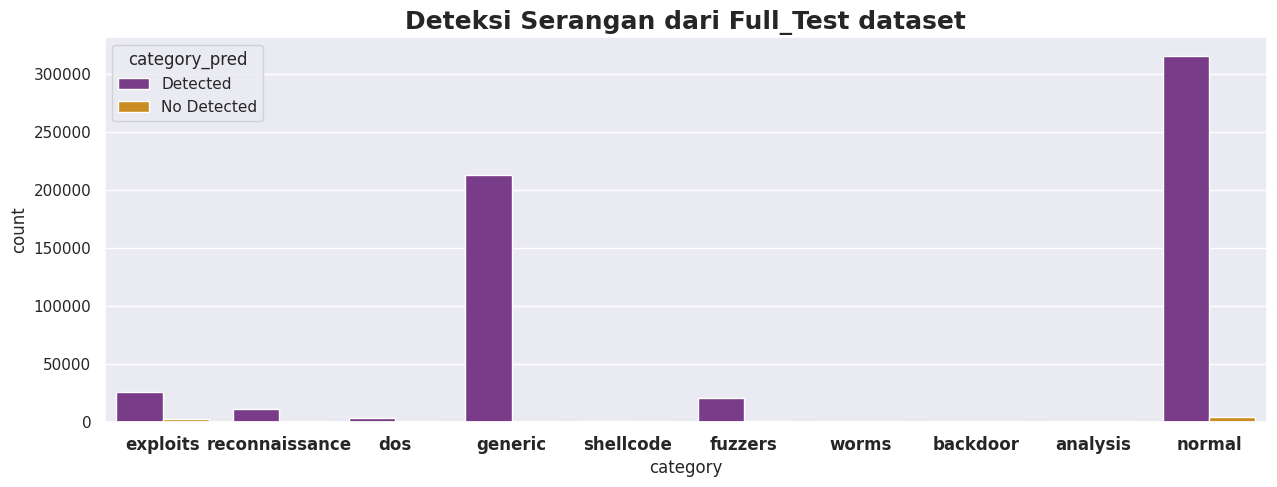

In [164]:
# Plotting target label distribution
plt.figure(figsize=(15,5))
sns.set_theme(style="darkgrid")
sns.countplot(x=data_plot3['category'], data=data_plot3,palette='CMRmap', hue=data_plot3['category_pred'])
plt.title('Deteksi Serangan dari Full_Test dataset', weight='bold', fontsize='18')
plt.xticks(weight='bold', fontsize=12)
plt.show()

In [165]:
summary4

Traffic  Detected %  No Detected %  Detected Samples  \
0          Normal   98.594168       1.405832            316086   
1        Analysis   97.588424       2.411576               607   
2        Backdoor   82.072829      17.927171               293   
3         Fuzzers   95.938095       4.061905             20643   
4       Shellcode   84.645930      15.354070              1279   
5           Worms   97.126437       2.873563               169   
6         Generic   99.919052       0.080948            213545   
7        Exploits   90.902991       9.097009             25741   
8  Reconnaissance   99.839717       0.160283             11835   
9             DoS   94.486151       5.513849              3650   

   No Detected Samples  
0                 4507  
1                   15  
2                   64  
3                  874  
4                  232  
5                    5  
6                  173  
7                 2576  
8                   19  
9                  213

In [166]:
summary4.to_csv('~/04_Semester_4/revisi/csv_files/summary_full_test.csv', index=False)